In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [85]:
def build_model_frame(df):
    """
    Create a leak-free modeling frame for forecasting dwelling_starts per province.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least: 'quarter', 'province',
        'dwelling_starts', 'pop_change_q', 'needed_units_q'

    Returns
    -------
    model_df : pandas.DataFrame
        Long-form table with lag features, ready for modeling.
    """
    # sort to guarantee time order within each province
    df = df.sort_values(["province", "quarter"]).copy()
    df["quarter"] = pd.PeriodIndex(df['quarter'], freq='Q').to_timestamp()


    # target
    df["y"] = df["dwelling_starts"]

    # one-quarter lags for baseline model (if i want to forecast next quarter)
    for col in ["dwelling_starts", "pop_change_q", "needed_units_q"]:
        df[f"{col}_lag1"] = df.groupby("province")[col].shift(1)

    # extra short-term memory + simple momentum (safe for h=1)
    df["dwelling_starts_lag2"] = df.groupby("province")["dwelling_starts"].shift(2)
    df["dwelling_starts_lag3"] = df.groupby("province")["dwelling_starts"].shift(3)
    df["diff1"] = df["dwelling_starts_lag1"] - df["dwelling_starts_lag2"]

    # quarter dummies (Q2–Q4; Q1 baseline)
    qdum = pd.get_dummies(df["quarter"].dt.quarter, prefix="q")
    df = pd.concat([df, qdum[[c for c in qdum.columns if c != "q_1"]]], axis=1)

    # same-quarter-last-year lag (4 quarters back) for the seasonal baseline model (if i want to forecast same q next year)
    df["dwelling_starts_lag4"] = df.groupby("province")["dwelling_starts"].shift(4)

    # drop rows where any lag is missing (first few quarters per province)
    feat_cols = [
        "dwelling_starts_lag1", #"dwelling_starts_lag2", "dwelling_starts_lag3",
        "dwelling_starts_lag4",
        "pop_change_q_lag1", "needed_units_q_lag1",
        #"diff1", "q_2", "q_3", "q_4"
    ]
    model_df = df.dropna(subset=["y"] + feat_cols).reset_index(drop=True)

    return model_df, feat_cols


In [86]:
df = pd.read_csv('data/housing_adequacy_dataset.csv')

model_df, feat_cols = build_model_frame(df)

In [87]:
model_df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,y,dwelling_starts_lag1,pop_change_q_lag1,needed_units_q_lag1,dwelling_starts_lag2,dwelling_starts_lag3,diff1,q_2,q_3,q_4,dwelling_starts_lag4
0,1991-01-01,ab,2572947.0,8.494667,2.123667,2123.666667,9805.0,3922.0,0.541475,2123.666667,2930.833333,15354.0,6141.6,3461.750000,5372.583333,-530.916667,False,False,False,5855.416667
1,1991-04-01,ab,2580625.0,12.852333,3.213083,3213.083333,7678.0,3071.2,1.046198,3213.083333,2123.666667,9805.0,3922.0,2930.833333,3461.750000,-807.166667,True,False,False,5372.583333
2,1991-07-01,ab,2592306.0,13.536333,3.384083,3384.083333,11681.0,4672.4,0.724271,3384.083333,3213.083333,7678.0,3071.2,2123.666667,2930.833333,1089.416667,False,True,False,3461.750000
3,1991-10-01,ab,2604031.0,14.018000,3.504500,3504.500000,11725.0,4690.0,0.747228,3504.500000,3384.083333,11681.0,4672.4,3213.083333,2123.666667,171.000000,False,False,True,2930.833333
4,1992-01-01,ab,2611786.0,16.100333,4.025083,4025.083333,7755.0,3102.0,1.297577,4025.083333,3504.500000,11725.0,4690.0,3384.083333,3213.083333,120.416667,False,False,False,2123.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,2024-07-01,sk,1247868.0,5.716333,1.429083,1429.083333,9277.0,3710.8,0.385115,1429.083333,883.333333,8275.0,3310.0,840.583333,1316.833333,42.750000,False,True,False,1263.000000
1525,2024-10-01,sk,1256983.0,4.590667,1.147667,1147.666667,9115.0,3646.0,0.314774,1147.666667,1429.083333,9277.0,3710.8,883.333333,840.583333,545.750000,False,False,True,1316.833333
1526,2025-01-01,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1525.416667,1147.666667,9115.0,3646.0,1429.083333,883.333333,-281.416667,False,False,False,840.583333
1527,2025-04-01,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1529.666667,1525.416667,4541.0,1816.4,1147.666667,1429.083333,377.750000,True,False,False,883.333333


In [88]:
model_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529 entries, 0 to 1528
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   quarter               1529 non-null   datetime64[ns]
 1   province              1529 non-null   object        
 2   population            1529 non-null   float64       
 3   starts_saar           1529 non-null   float64       
 4   starts_saar_q         1529 non-null   float64       
 5   dwelling_starts       1529 non-null   float64       
 6   pop_change_q          1529 non-null   float64       
 7   needed_units_q        1529 non-null   float64       
 8   hai                   1529 non-null   float64       
 9   y                     1529 non-null   float64       
 10  dwelling_starts_lag1  1529 non-null   float64       
 11  pop_change_q_lag1     1529 non-null   float64       
 12  needed_units_q_lag1   1529 non-null   float64       
 13  dwelling_starts_la

In [89]:
feat_cols

['dwelling_starts_lag1',
 'dwelling_starts_lag4',
 'pop_change_q_lag1',
 'needed_units_q_lag1']

In [90]:
#checking and converting the quarter to datetime if it was object before
if model_df["quarter"].dtype == "O":
    model_df['quarter'] = pd.PeriodIndex(model_df['quarter'], freq='Q').to_timestamp()

## Data splitting

In [91]:
def chrono_split(df, cutoff="2018-12-31"):
    
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

"""
    Expanding-window backtest.
      - initial: first train end date (Timestamp or str). If None, uses 60% of timeline.
      - step: how many quarters to advance the train end each fold.
      - fh: forecast horizon in quarters (size of the test slice each fold).
    Yields (train_df, test_df) pairs over the whole *panel* (all provinces).
"""
def rolling_split(df,
                  initial=None,
                  step=1,
                  fh=2):
 
    dates = np.sort(df["quarter"].unique())
    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)

    # find index of initial in the date array
    # (if not exact, snap to the nearest past available quarter)
    start_idx = np.searchsorted(dates, initial, side="right") - 1
    start_idx = max(start_idx, 0)

    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te

In [92]:
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8 #to avoid a zero denominator
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def metrics_by_province(test_df, target_col="dwelling_starts", pred_col="dwelling_starts_lag1"):
    rows = []
    for prov, g in test_df.groupby("province"):
        y_true = g[target_col]
        y_pred = g[pred_col]
        res = metrics(y_true, y_pred)
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")


In [93]:
def mase(y_true, y_pred, y_train, season=1):
    """Mean Absolute Scaled Error (compare to naive lag=season)."""
    # Naive forecast errors on the training set
    naive_forecast = y_train.shift(season)
    mae_naive = np.mean(np.abs(y_train[season:] - naive_forecast[season:]))
    
    # Model forecast errors on the test set
    mae_model = np.mean(np.abs(y_true - y_pred))
    
    return mae_model / mae_naive

In [94]:
train, test = chrono_split(model_df)
#metrics for the seasonal naive where last quarter's data is used as last year’s same-quarter value as a guess for this year’s quarter.
prov_metrics_naive = metrics_by_province(test) 
print(prov_metrics_naive)
print("\nAverage across provinces:", prov_metrics_naive.mean())

                  MAE         RMSE      sMAPE
province                                     
ab        1295.217593  1634.832277  14.969214
bc        1639.475309  2157.417083  14.514373
can       4892.203704  6322.626935   8.221017
mb         344.381173   415.797137  18.497863
nb         347.026235   410.534163  35.107962
nl          84.750000   101.995775  29.185107
ns         421.000000   570.385958  26.472511
on        2524.785494  2974.894971  12.437392
pe          95.824074   123.023157  32.344386
qc        2002.938272  2526.819942  15.406655
sk         235.009259   311.764200  23.291171

Average across provinces: MAE      1262.055556
RMSE     1595.462873
sMAPE      20.949787
dtype: float64


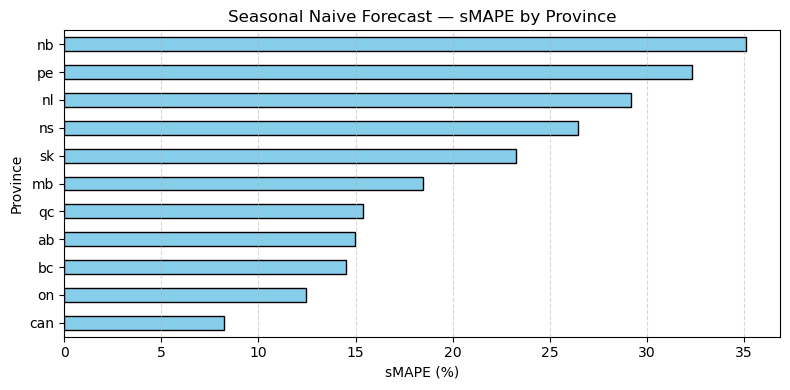

In [95]:
plt.figure(figsize=(8, 4))
prov_metrics_naive["sMAPE"].sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("sMAPE (%)")
plt.ylabel("Province")
plt.title("Seasonal Naive Forecast — sMAPE by Province")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [96]:
#Linear Regression

def linreg_metrics_by_province(train_df, test_df, features, target="dwelling_starts"):
    rows = []
    for prov, gtrain in train_df.groupby("province"):
        gtest = test_df[test_df["province"] == prov]
        if gtest.empty:
            continue
        # Train model for this province
        X_train = gtrain[features]
        y_train = gtrain[target]
        X_test  = gtest[features]
        y_test  = gtest[target]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        res = metrics(y_test, y_pred)   # your existing metrics() function
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")

In [97]:
prov_linreg = linreg_metrics_by_province(train, test, features=feat_cols)
print(prov_linreg)
print("\nAverage across provinces:\n", prov_linreg.mean())

                  MAE         RMSE      sMAPE
province                                     
ab        1302.481692  1636.434612  15.156008
bc        1473.227014  1980.499626  13.057306
can       5306.149258  6780.431932   9.087720
mb         289.706620   376.393738  15.411909
nb         391.988532   453.286344  39.073738
nl         166.621183   201.814321  44.620260
ns         499.274695   704.496340  30.875825
on        2259.281571  2723.276547  11.218281
pe          87.386006   119.080920  29.849334
qc        1968.744820  2547.999956  15.064578
sk         224.795394   280.859041  22.070113

Average across provinces:
 MAE      1269.968799
RMSE     1618.597580
sMAPE      22.316825
dtype: float64


In [98]:
y_train = train["dwelling_starts"]
y_true  = test["dwelling_starts"]

In [99]:
MODEL_REGISTRY = {
    "lr": lambda **kw: make_pipeline(StandardScaler(), LinearRegression(**kw)),
    "rf": lambda **kw: RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, **kw),
    "ridge": lambda **kw: make_pipeline(StandardScaler(), Ridge(alpha=1.0, **kw)),
    "xgb": lambda **kw: XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, **kw),
}

def run_model(name, train, test, features, target="dwelling_starts", per_province=False, **model_kwargs):
    model = MODEL_REGISTRY[name](**model_kwargs)
    if not per_province:
        Xtr, ytr = train[features], train[target]
        Xte, yte = test[features],  test[target]
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        return ypred, metrics(yte, ypred)  # uses your existing metrics()
    else:
        rows = []
        for prov, gtr in train.groupby("province"):
            gte = test[test["province"] == prov]
            if gte.empty: 
                continue
            m = MODEL_REGISTRY[name](**model_kwargs)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)
            res = metrics(yte, ypred)
            res["province"] = prov
            rows.append(res)
        import pandas as pd
        return pd.DataFrame(rows).set_index("province")


In [100]:
models = ['lr', 'rf', 'ridge', 'xgb',]

In [101]:
rows = []
for prov, gtr in train.groupby("province"):
    gte = test[test["province"] == prov]
    if gte.empty: 
        continue
    y_train = gtr["dwelling_starts"]
    y_true  = gte["dwelling_starts"]
    for name in models:
        m = MODEL_REGISTRY[name]()  # build model
        Xtr, Xte = gtr[feat_cols], gte[feat_cols]
        m.fit(Xtr, y_train)
        y_pred = m.predict(Xte)
        row = metrics(y_true, y_pred)  # MAE/RMSE/sMAPE
        row["MASE"] = mase(y_true, y_pred, y_train, season=1)
        row["model"] = name
        row["province"] = prov
        rows.append(row)
prov_cmp = pd.DataFrame(rows).set_index(["province","model"])
print(prov_cmp)

                        MAE          RMSE      sMAPE      MASE
province model                                                
ab       lr     1302.481692   1636.434612  15.156008  1.686631
         rf     1363.407238   1760.270115  15.989034  1.765526
         ridge  1281.456536   1621.738889  14.911307  1.659405
         xgb    1525.179404   1922.044359  18.258305  1.975010
bc       lr     1473.227014   1980.499626  13.057306  1.943931
         rf     1664.408642   2064.330922  15.041118  2.196197
         ridge  1472.898903   1974.900397  13.066256  1.943498
         xgb    1702.699472   2034.153758  15.371228  2.246721
can      lr     5306.659776   6781.197332   9.088532  1.904548
         rf     7854.188395   9149.713577  13.347582  2.818851
         ridge  5258.030216   6738.823189   9.009283  1.887095
         xgb    9602.372541  11006.882001  16.570593  3.446270
mb       lr      289.706620    376.393738  15.411909  1.258571
         rf      301.198086    377.927456  16.677967  1

In [102]:
holdout_avg = (
    prov_cmp.groupby("model")[["MAE","RMSE","sMAPE","MASE"]]
            .mean()
            .round(2)
)
display(holdout_avg)

,MAE,RMSE,sMAPE,MASE
model,,,,
lr,1270.02,1618.67,22.32,1.68
rf,1616.40,1965.86,26.55,1.99
ridge,1269.08,1621.78,22.37,1.68
xgb,1828.98,2183.23,29.96,2.22


In [103]:
# Helper: naive MAE on TRAIN (lag = season; for 1-step use season=1)
def _naive_mae_train(y_train: pd.Series, season: int = 1, eps: float = 1e-12) -> float:
    y = y_train.to_numpy()
    if len(y) <= season: 
        return np.nan
    denom = np.mean(np.abs(y[season:] - y[:-season]))
    return max(denom, eps)  # guard against divide-by-zero

# 1) Rolling CV — overall (all provinces combined)
def rolling_cv_overall(df, models, features, target="dwelling_starts", fh=1, initial=None):
    rows = []
    for tr, te in rolling_split(df, initial=initial, fh=fh):
        cutoff = tr["quarter"].max()
        denom = _naive_mae_train(tr[target], season=1)
        for name in models:
            y_pred, res = run_model(name, tr, te, features, target)  # uses your registry
            res["MASE"] = res["MAE"] / denom
            res["model"] = name
            res["cutoff"] = cutoff
            rows.append(res)
    return pd.DataFrame(rows).set_index(["cutoff", "model"]).sort_index()

# 2) Rolling CV — per-province
def rolling_cv_by_province(df, models, features, target="dwelling_starts", fh=1, initial=None):
    out = []
    for tr, te in rolling_split(df, initial=initial, fh=fh):
        cutoff = tr["quarter"].max()
        # denom per province from TRAIN
        denoms = {
            prov: _naive_mae_train(g[target], season=1)
            for prov, g in tr.groupby("province")
        }
        for name in models:
            # reuse your per-province branch; returns DF indexed by province with MAE/RMSE/sMAPE
            df_m = run_model(name, tr, te, features, target, per_province=True).copy()
            df_m["MASE"] = df_m["MAE"] / df_m.index.map(lambda p: max(denoms.get(p, np.nan), 1e-12))
            df_m["model"] = name
            df_m["cutoff"] = cutoff
            out.append(df_m.reset_index())
    return pd.concat(out, ignore_index=True).set_index(["cutoff", "province", "model"]).sort_index()


In [104]:
# Run rolling over the full dataframe you want to evaluate (e.g., model_df or df_v2)
overall_cv = rolling_cv_overall(model_df, models, feat_cols, fh=1)            # combined metrics + MASE per cutoff/model
prov_cv    = rolling_cv_by_province(model_df, models, feat_cols, fh=1)        # per-province metrics + MASE per cutoff/model

print(overall_cv.groupby("model").mean(numeric_only=True))  # average across folds
print(prov_cv.groupby(["province","model"]).mean(numeric_only=True))      # per-province averages

               MAE         RMSE      sMAPE      MASE
model                                               
lr     1015.334925  1660.130982  19.293833  1.211479
rf     1105.996471  1846.942240  19.717571  1.315930
ridge  1006.546231  1645.238672  19.083809  1.201056
xgb    1173.334421  2012.690157  19.041095  1.395590
                        MAE         RMSE      sMAPE      MASE
province model                                               
ab       lr     1127.823253  1127.823253  13.514264  1.450494
         rf     1195.323091  1195.323091  14.100183  1.541313
         ridge  1113.333036  1113.333036  13.328274  1.431842
         xgb    1295.826438  1295.826438  15.592311  1.669206
bc       lr     1112.113310  1112.113310  10.779262  1.398329
         rf     1186.450659  1186.450659  11.800604  1.493248
         ridge  1099.943284  1099.943284  10.665718  1.383432
         xgb    1309.374012  1309.374012  13.279281  1.651871
can      lr     3753.352097  3753.352097   6.789528  1.290812


In [105]:
rolling_avg = (
    prov_cv.groupby("model")[["MAE","RMSE","sMAPE","MASE"]]
           .mean()
           .round(2)
)
display(rolling_avg)

,MAE,RMSE,sMAPE,MASE
model,,,,
lr,998.64,998.64,18.23,1.30
rf,1069.10,1069.10,19.72,1.39
ridge,1000.94,1000.94,18.22,1.30
xgb,1225.63,1225.63,21.32,1.52


In [106]:
summary = (
    prov_cv.groupby('province')[["MAE","RMSE","sMAPE","MASE"]]
           .mean()
           .round(1)
           .sort_values("MAE")
)
display(summary)

,MAE,RMSE,sMAPE,MASE
province,,,,
pe,71.9,71.9,31.2,1.2
nl,133.0,133.0,31.4,1.2
nb,206.6,206.6,24.9,1.0
sk,278.9,278.9,21.2,1.4
mb,304.4,304.4,17.6,1.4
ns,373.9,373.9,28.1,1.5
bc,1177.0,1177.0,11.6,1.5
ab,1183.1,1183.1,14.1,1.5
qc,1648.0,1648.0,14.1,1.7


,Holdout,Rolling,Delta
model,,,
lr,1.68,1.30,-0.38
ridge,1.68,1.30,-0.38
rf,1.99,1.39,-0.60
xgb,2.22,1.52,-0.70


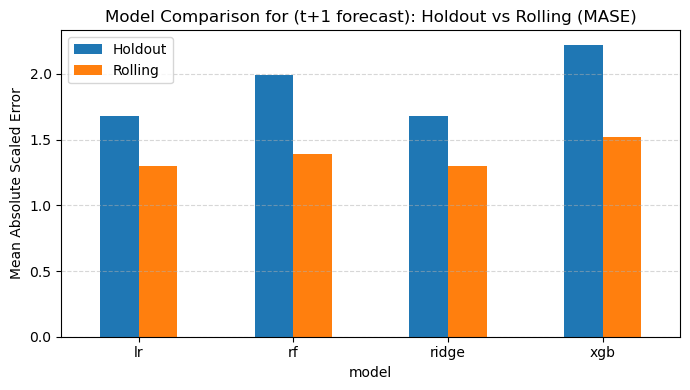

In [107]:
compare1 = pd.concat(
    [holdout_avg["MASE"].rename("Holdout"),
     rolling_avg["MASE"].rename("Rolling")],
    axis=1
).assign(Delta=lambda d: d["Rolling"] - d["Holdout"]).round(3)
display(compare1.sort_values("Rolling"))

compare = pd.concat(
    [holdout_avg["MASE"].rename("Holdout"),
     rolling_avg["MASE"].rename("Rolling")],
    axis=1
).round(3)

compare.plot(kind="bar", figsize=(7,4))
plt.title("Model Comparison for (t+1 forecast): Holdout vs Rolling (MASE)")
plt.ylabel("Mean Absolute Scaled Error")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

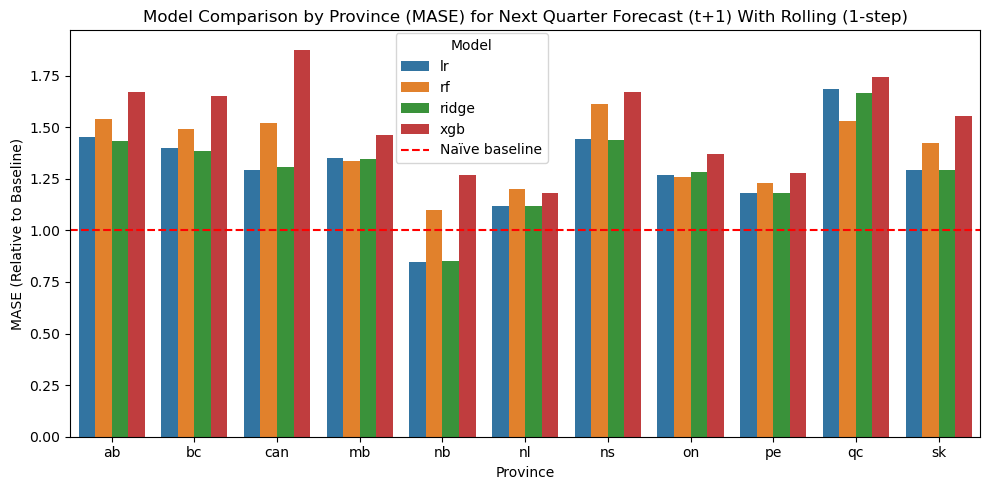

In [115]:
metric = "MASE"
plot_df = (
    prov_cv.groupby(["province", "model"])[metric]
           .mean()
           .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=plot_df, x="province", y=metric, hue="model")
plt.axhline(1.0, color="red", linestyle="--", label="Naïve baseline")
plt.title(f"Model Comparison by Province ({metric}) for Next Quarter Forecast (t+1) With Rolling (1-step)")
plt.ylabel(f"{metric} (Relative to Baseline)")
plt.xlabel("Province")
plt.legend(title="Model", bbox_to_anchor=(.35, 1.01), loc="upper left")
plt.tight_layout()
plt.show()

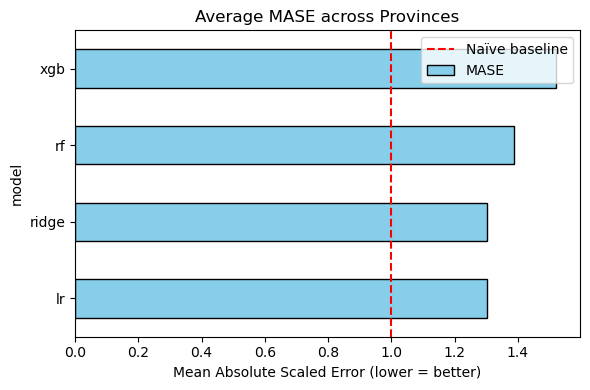

In [25]:
# Compute average MASE across provinces for each model
summary_mase = (
    prov_cv.groupby("model")["MASE"]
           .mean()
           .sort_values()
)

plt.figure(figsize=(6,4))
summary_mase.plot(kind="barh", color="skyblue", edgecolor="black")

# Baseline line at 1.0
plt.axvline(1.0, color="red", linestyle="--", linewidth=1.5, label="Naïve baseline")

plt.title("Average MASE across Provinces")
plt.xlabel("Mean Absolute Scaled Error (lower = better)")
plt.legend()
plt.tight_layout()
plt.show()

### With the holdout set, using only Linear Regression as is seems to be the best model

In [26]:
name = "lr"  # or "ridge", "rf", "xgb"
m_preds = []

for prov, gtr in train.groupby("province"):
    gte = test[test["province"] == prov]
    if gte.empty:
        continue

    model = MODEL_REGISTRY[name]()  # new model per province
    Xtr, ytr = gtr[feat_cols], gtr["y"]
    Xte, yte = gte[feat_cols], gte["y"]

    model.fit(Xtr, ytr)
    m_preds.append(pd.DataFrame({
        "province": prov,
        "quarter": gte["quarter"].values,
        "y_true": yte.values,
        "y_pred": model.predict(Xte)
    }))

preds_all = pd.concat(m_preds, ignore_index=True)
preds_all.head()

,province,quarter,y_true,y_pred
0,ab,2019-01-01,5398.500000,5484.116847
1,ab,2019-04-01,6701.166667,5415.045931
2,ab,2019-07-01,7826.666667,6685.839057
3,ab,2019-10-01,7426.166667,8033.221553
4,ab,2020-01-01,5989.500000,7756.792770


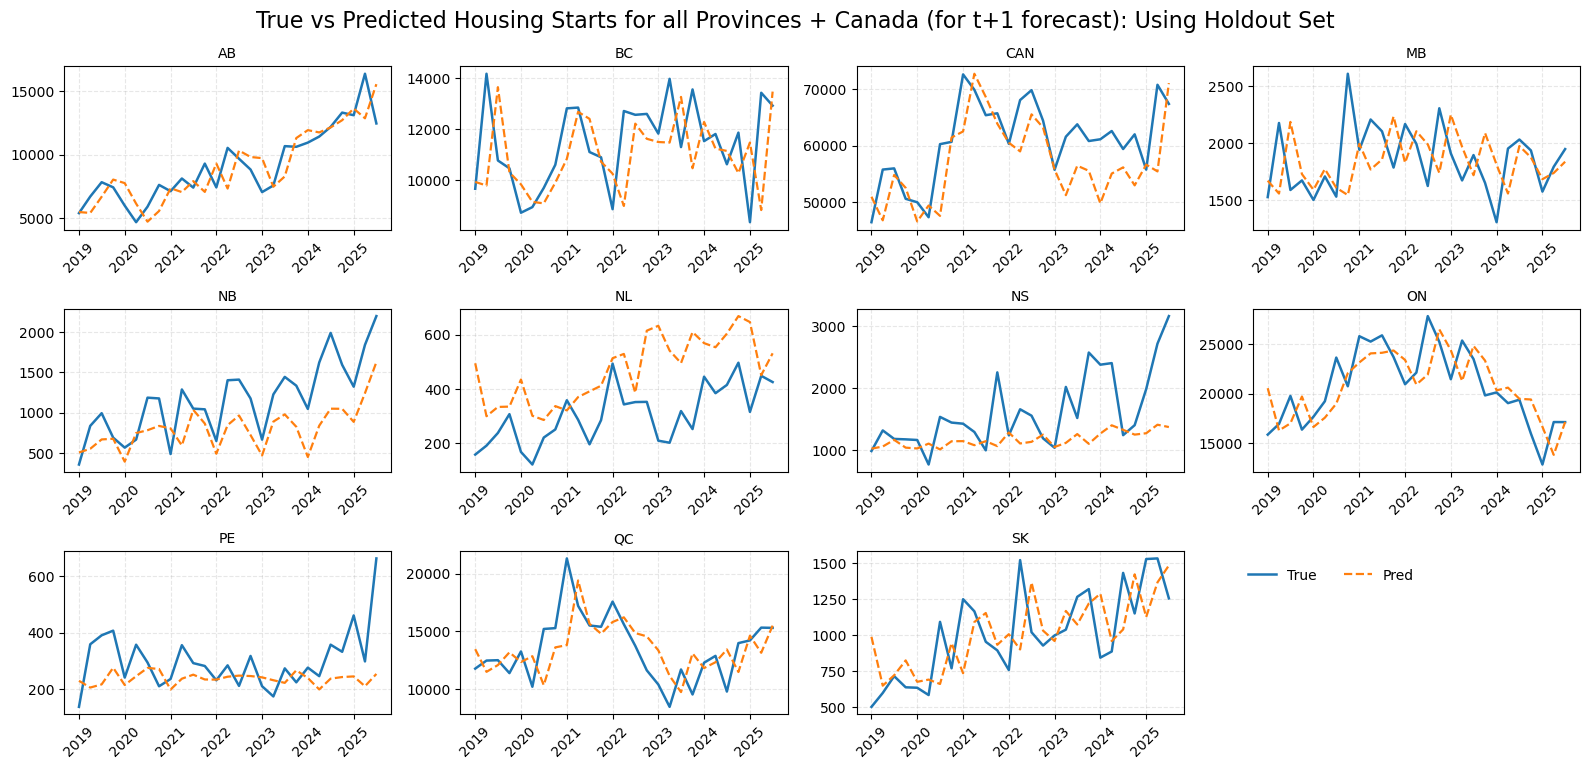

In [113]:
# Assumes you already built `preds_all` with columns: province, quarter, y_true, y_pred
provs = sorted(preds_all["province"].unique())
n = len(provs)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
axes = axes.ravel()

for i, prov in enumerate(provs):
    ax = axes[i]
    g = preds_all[preds_all["province"] == prov].sort_values("quarter")
    ax.plot(g["quarter"], g["y_true"], label="True", linewidth=1.8)
    ax.plot(g["quarter"], g["y_pred"], "--", label="Pred", linewidth=1.6)
    ax.set_title(prov.upper(), fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(True, linestyle="--", alpha=0.3)

# Hide any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.835, .23))

fig.suptitle("True vs Predicted Housing Starts for all Provinces + Canada (for t+1 forecast): Using Holdout Set", y=.98, fontsize=16)
plt.tight_layout()
plt.show()

## With rolling window set:

In [122]:
name = "lr"
rows = []
for tr, te in rolling_split(model_df, initial=None, fh=1):
    cutoff = tr["quarter"].max()
    for prov, gtr in tr.groupby("province"):
        gte = te[te["province"] == prov]
        if gte.empty:
            continue
        model = MODEL_REGISTRY[name]()
        Xtr, ytr = gtr[feat_cols], gtr["y"]
        Xte, yte = gte[feat_cols], gte["y"]
        model.fit(Xtr, ytr)
        rows.append(pd.DataFrame({
            "cutoff": cutoff,
            "province": prov,
            "quarter": gte["quarter"].values,
            "y_true": yte.values,
            "y_pred": model.predict(Xte)
        }))

preds_rolling_all_folds = pd.concat(rows, ignore_index=True)
preds_rolling_all_folds.head(50)

,cutoff,province,quarter,y_true,y_pred
0,2011-10-01,ab,2012-01-01,7705.083333,8043.870534
1,2011-10-01,bc,2012-01-01,6845.333333,6367.162696
2,2011-10-01,can,2012-01-01,51992.750000,47947.698590
3,2011-10-01,mb,2012-01-01,1706.000000,1489.784963
4,2011-10-01,nb,2012-01-01,579.500000,655.623840
5,2011-10-01,nl,2012-01-01,1017.500000,835.436984
6,2011-10-01,ns,2012-01-01,958.333333,1089.008740
7,2011-10-01,on,2012-01-01,19946.583333,16609.075352
8,2011-10-01,pe,2012-01-01,115.333333,189.076552
9,2011-10-01,qc,2012-01-01,10910.250000,11703.788344


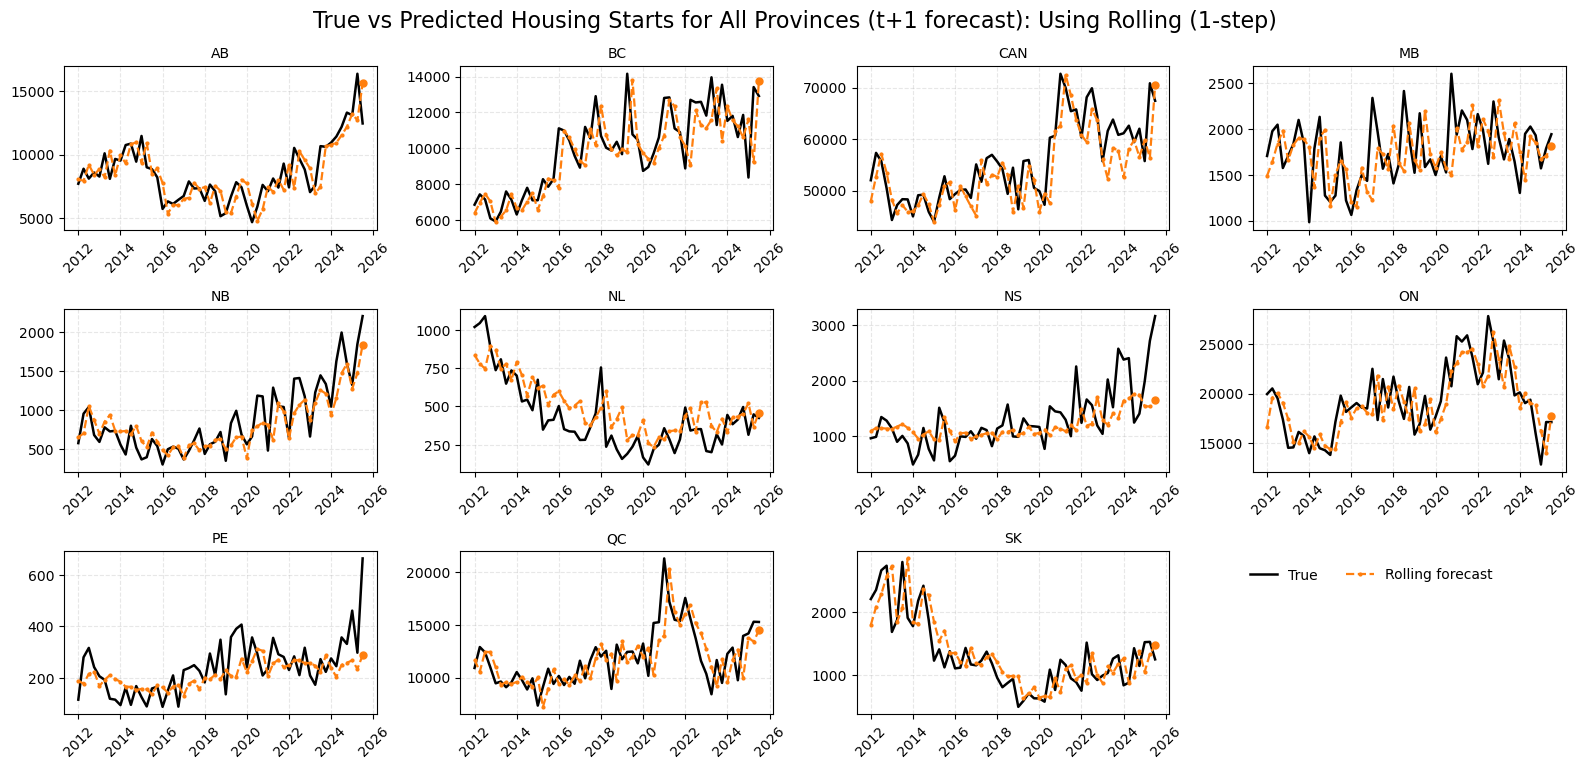

In [121]:
# Use your rolling dataframe
df = preds_rolling_all_folds.copy()
df["quarter"] = pd.to_datetime(df["quarter"])
df = df.sort_values(["province","quarter"])

provs = sorted(df["province"].unique())
cols, rows = 4, math.ceil(len(provs)/4)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
axes = axes.ravel()

for i, prov in enumerate(provs):
    ax = axes[i]
    g = df[df["province"] == prov]

    # True series
    truth = g.drop_duplicates("quarter")[["quarter","y_true"]]
    ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.8, label="True")

    # Rolling 1-step forecasts connected over time
    ax.plot(g["quarter"], g["y_pred"], "--", marker="o", ms=2,
            color="tab:orange", lw=1.6, label="Rolling forecast")

    # Emphasize latest forecast point
    ax.plot(g["quarter"].iloc[-1], g["y_pred"].iloc[-1], "o", color="tab:orange", ms=5)

    ax.set_title(prov.upper(), fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(True, ls="--", alpha=0.3)

# Hide any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.86, .23))

fig.suptitle("True vs Predicted Housing Starts for All Provinces (t+1 forecast): Using Rolling (1-step)", y=.98, fontsize=16)
plt.tight_layout()
plt.show()